In [11]:
import pandas as pd

df = pd.read_csv('imdb_cleaned.csv')
df.columns

Index(['startYear', 'runtimeMinutes', 'totalCredits', 'numRegions',
       'ratingCount', 'castNumber', 'companiesNumber', 'writerCredits',
       'directorsCredits', 'totalNominations', 'totalMedia', 'totalReviews',
       'Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania',
       'Continent Unknown', 'genre1', 'genre2', 'genre3', 'movie', 'short',
       'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort',
       'tvSpecial', 'video', 'videoGame', 'rating_bin'],
      dtype='object')

In [12]:
# df = df.loc[df['videoGame'] == 0]

df['movie'] = (df['movie'] | (df['tvMovie'])).astype(int)
df['short'] = (df['short'] | (df['tvShort'])).astype(int)
df['tvSeries'] = (df['tvSeries'] | (df['tvMiniSeries'])).astype(int)
df.drop(columns=['tvMiniSeries', 'tvMovie', 'tvShort','videoGame'], inplace=True)

df.columns

Index(['startYear', 'runtimeMinutes', 'totalCredits', 'numRegions',
       'ratingCount', 'castNumber', 'companiesNumber', 'writerCredits',
       'directorsCredits', 'totalNominations', 'totalMedia', 'totalReviews',
       'Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania',
       'Continent Unknown', 'genre1', 'genre2', 'genre3', 'movie', 'short',
       'tvEpisode', 'tvSeries', 'tvSpecial', 'video', 'rating_bin'],
      dtype='object')

In [13]:
titletype_cols = [
    'movie', 'short', 'tvEpisode',
    'tvSeries', 'tvSpecial', 'video'
]

In [14]:
# Train-test-val split
from turtle import title
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[titletype_cols])
train, val = train_test_split(train, test_size=0.25, random_state=42, stratify=train[titletype_cols])

X_train = train.drop(columns=titletype_cols)
y_train = train[titletype_cols]

X_val = val.drop(columns=titletype_cols)
y_val = val[titletype_cols]

X_test = test.drop(columns=titletype_cols)
y_test = test[titletype_cols]

In [15]:
# Feature selection
numerical_cols = [
    'startYear', 'runtimeMinutes', 'totalCredits',
    'numRegions', 'ratingCount', 'castNumber',
    'companiesNumber', 'writerCredits', 'directorsCredits',
    'totalNominations', 'totalMedia', 'totalReviews',
    'rating_bin'
]

region_cols = [
    'Asia', 'Africa', 'Europe',
    'North America', 'South America', 'Oceania',
    'Continent Unknown'
]

genre_cols = ['genre1', 'genre2', 'genre3']

selected_features = numerical_cols + region_cols + genre_cols

# selected_features / titletype_cols
to_scale = [feat for feat in selected_features if feat not in titletype_cols]

genre_cols = ['genre1', 'genre2', 'genre3']

X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

In [ ]:
from re import X
import numpy as np

to_log = [
       'numRegions', 'ratingCount', 'companiesNumber',
       'totalNominations', 'totalMedia', 'totalReviews']
       # 'deltaCredits'


# Apply log transformation safely (fill NaN, clip negatives)
for col in to_log:
    X_train[col] = np.log1p(X_train[col].fillna(0).clip(lower=0))
    X_val[col] = np.log1p(X_val[col].fillna(0).clip(lower=0))
    X_test[col] = np.log1p(X_test[col].fillna(0).clip(lower=0))

In [17]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_val[to_scale] = scaler.transform(X_val[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

In [249]:
# from sklearn.preprocessing import LabelEncoder

# # One-hot encode y_train for categorical_crossentropy
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)

In [18]:
# Prepare input
X_train = {
    'numerical': X_train[numerical_cols].values,
    'region': X_train[region_cols].values,
    'genre': X_train[genre_cols].values
}

X_val = {
    'numerical': X_val[numerical_cols].values,
    'region': X_val[region_cols].values,
    'genre': X_val[genre_cols].values
}

X_test = {
    'numerical': X_test[numerical_cols].values,
    'region': X_test[region_cols].values,
    'genre': X_test[genre_cols].values
}

In [19]:
y_train

,movie,short,tvEpisode,tvSeries,tvSpecial,video
78655,1,0,0,0,0,0
14065,1,0,0,0,0,0
118462,0,1,0,0,0,0
30267,1,0,0,0,0,0
78049,0,0,0,0,0,0
...,...,...,...,...,...,...
48556,0,0,1,0,0,0
126710,0,0,1,0,0,0
98862,0,0,1,0,0,0
31983,0,1,0,0,0,0


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf

# Numerical input
numerical_input = layers.Input(shape=(len(numerical_cols),), name='numerical')

numerical_branch = layers.Dense(112, use_bias=False)(numerical_input)
numerical_branch = layers.BatchNormalization()(numerical_branch)
numerical_branch = layers.Activation('relu')(numerical_branch)

# region branch
region_input = layers.Input(shape=(len(region_cols),), name='region')

region_branch = layers.Dense(8, use_bias=False)(region_input)
region_branch = layers.BatchNormalization()(region_branch)
region_branch = layers.Activation('relu')(region_branch)

# genre branch
genre_input = layers.Input(shape=(len(genre_cols),), name='genre')

genre_branch = layers.Dense(8, use_bias=False)(genre_input)
genre_branch = layers.BatchNormalization()(genre_branch)
genre_branch = layers.Activation('relu')(genre_branch)


# Concatenate all branches
concatenated = layers.concatenate([numerical_branch, region_branch, genre_branch])

# 1st layer
x = layers.Dense(64, use_bias=False)(concatenated)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

# 2nd layer
x = layers.Dense(32, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)


# Output layer
output = layers.Dense(len(titletype_cols), activation='softmax')(x)

model = tf.keras.Model(
    inputs=[numerical_input, region_input, genre_input],
    outputs=output
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical           │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ region (InputLayer) │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre (InputLayer)  │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 112)       │      1,456 │ numerical[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │         56 │ region[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │         24 │ genre[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112)       │        448 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 112)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 8)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 8)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ activation_5[0][… │
│ (Concatenate)       │                   │            │ activation_6[0][… │
│                     │                   │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,192 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,048 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 12,870 (50.27 KB)

 Trainable params: 12,422 (48.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
%%time
from sklearn.utils.class_weight import compute_class_weight

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(titletype_cols)),
    y=np.argmax(y_train.values, axis=1)
)
class_weights = {i: class_weights[i] for i in range(len(titletype_cols))}  # Convert to dict for Keras

history = model.fit(
    X_train, y_train,
    epochs=500, batch_size=64, validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, 
        restore_best_weights=True
    )],
    class_weight=class_weights
)

Epoch 1/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3179 - loss: 1.4302 - val_accuracy: 0.6353 - val_loss: 1.1036
Epoch 2/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6639 - loss: 0.9729 - val_accuracy: 0.7728 - val_loss: 0.7524
Epoch 3/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7442 - loss: 0.8367 - val_accuracy: 0.8125 - val_loss: 0.5840
Epoch 4/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7784 - loss: 0.7539 - val_accuracy: 0.8264 - val_loss: 0.5191
Epoch 5/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7897 - loss: 0.7166 - val_accuracy: 0.8361 - val_loss: 0.4752
Epoch 6/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7972 - loss: 0.6945 - val_accuracy: 0.8382 - val_loss: 0.4525
Epoch 7/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8044 - loss: 0.6645 - val_accuracy: 0.8427 - val_loss: 0.4340
Epoch 8/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8095 - loss: 0

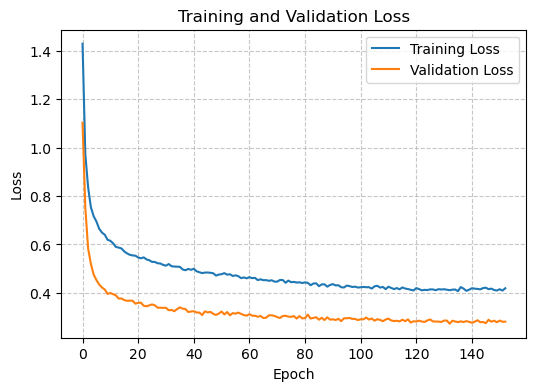

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

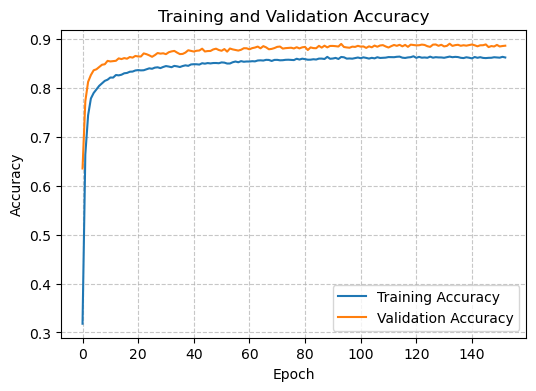

906/906 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


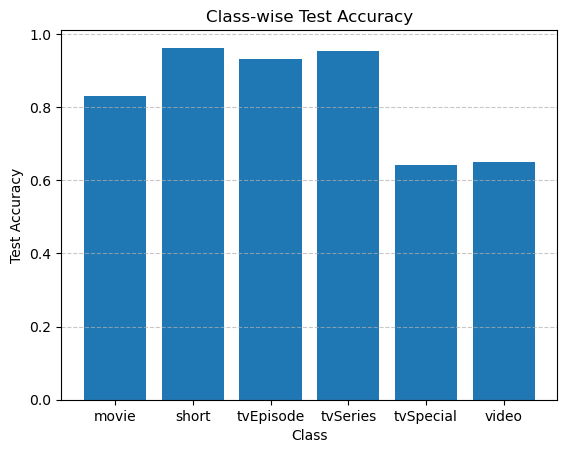

In [23]:
from sklearn.metrics import accuracy_score

# Plot overall accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

# Class-wise accuracy on test set

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate accuracy for each class
class_accuracies = {}
for i, class_name in enumerate(titletype_cols):
    idx = (y_test.values.argmax(axis=1) == i)
    class_acc = accuracy_score(y_test.values.argmax(axis=1)[idx], y_pred_classes[idx])
    class_accuracies[class_name] = class_acc

# Plot class-wise accuracy
plt.bar(class_accuracies.keys(), class_accuracies.values())
plt.xlabel('Class')
plt.ylabel('Test Accuracy')
plt.title('Class-wise Test Accuracy')
# plt.xticks(rotation=45)
plt.grid(alpha=0.7, linestyle='--', axis='y')
plt.show()

906/906 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

       movie       0.97      0.83      0.89      8749
       short       0.88      0.96      0.92      3087
   tvEpisode       0.99      0.93      0.96     13937
    tvSeries       0.82      0.95      0.88      2006
   tvSpecial       0.17      0.64      0.27       215
       video       0.36      0.65      0.46       989

    accuracy                           0.89     28983
   macro avg       0.70      0.83      0.73     28983
weighted avg       0.93      0.89      0.91     28983



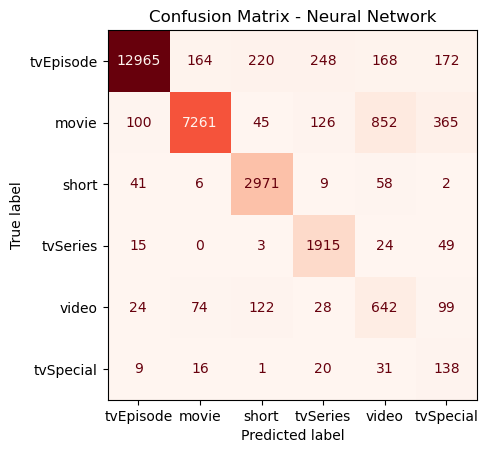

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


# Predict on the test set
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.values.argmax(axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=titletype_cols))

report = classification_report(y_true, y_pred, target_names=titletype_cols, output_dict=True)
support = [report[label]['support'] for label in titletype_cols]
sorted_indices = sorted(range(len(support)), key=lambda k: support[k], reverse=True)
sorted_labels = [titletype_cols[i] for i in sorted_indices]

# 1. Manually create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(titletype_cols)))

# 2. Sort the confusion matrix based on the sorted_indices
cm_sorted = cm[sorted_indices, :]  # Sort rows
cm_sorted = cm_sorted[:, sorted_indices] # Sort columns

# 3. Create a new ConfusionMatrixDisplay object with the sorted matrix and sorted labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=sorted_labels)
disp.xticks_rotation = 45

# 4. Plot the sorted confusion matrix
disp.plot(cmap='Reds', colorbar=False)

plt.title('Confusion Matrix - Neural Network')


plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

906/906 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


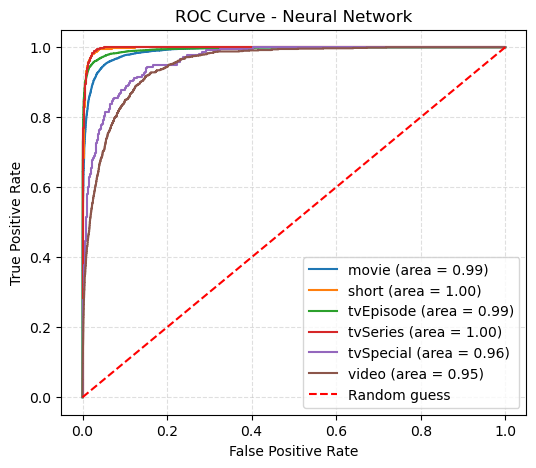

In [25]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
# Convert y_test to single-label array
y_true = y_test.values.argmax(axis=1)
y_score = model.predict(X_test)

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(titletype_cols[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

In [27]:
# Save model
model.save('neural_net_titletype.keras')

# Rating

In [34]:
import pandas as pd

df = pd.read_csv('imdb_cleaned.csv')
df.columns

Index(['startYear', 'runtimeMinutes', 'totalCredits', 'numRegions',
       'ratingCount', 'castNumber', 'companiesNumber', 'writerCredits',
       'directorsCredits', 'totalNominations', 'totalMedia', 'totalReviews',
       'Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania',
       'Continent Unknown', 'genre1', 'genre2', 'genre3', 'movie', 'short',
       'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort',
       'tvSpecial', 'video', 'videoGame', 'rating_bin'],
      dtype='object')

In [35]:
numerical_cols = [
    'startYear', 'runtimeMinutes', 'totalCredits',
    'numRegions', 'ratingCount', 'castNumber',
    'companiesNumber', 'writerCredits', 'directorsCredits',
    'totalNominations', 'totalMedia', 'totalReviews',
]

titletype_cols = [
    'movie', 'short', 'tvEpisode',
    'tvSeries', 'tvSpecial', 'video',
]

region_cols = [
    'Asia', 'Africa', 'Europe',
    'North America', 'South America', 'Oceania',
    'Continent Unknown'
]

genre_cols = ['genre1', 'genre2', 'genre3']

to_scale = [feat for feat in numerical_cols+region_cols+genre_cols]

In [36]:
X = df.drop(columns=['rating_bin'])
y = df['rating_bin']

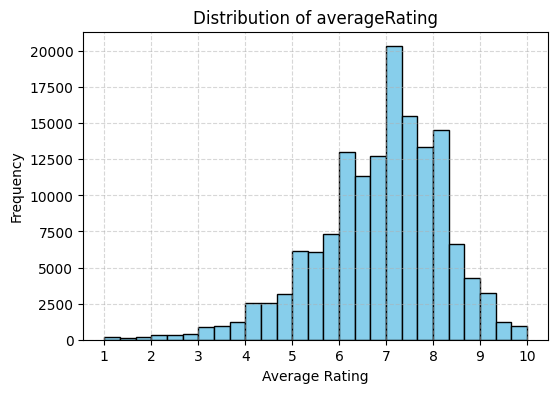

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(6, 4))
# plt.hist(y, bins=27, color='skyblue', edgecolor='black')
# # Add line plot for visualizing the continuous nature of ratings
# # plt.plot(y_train, , 'x', alpha=0.5)
# plt.xlabel('Average Rating')
# plt.ylabel('Frequency')
# plt.xticks(range(1,11))
# # plt.yscale('log')
# plt.title('Distribution of averageRating')
# plt.grid(alpha=0.5, linestyle='--')
# plt.show()

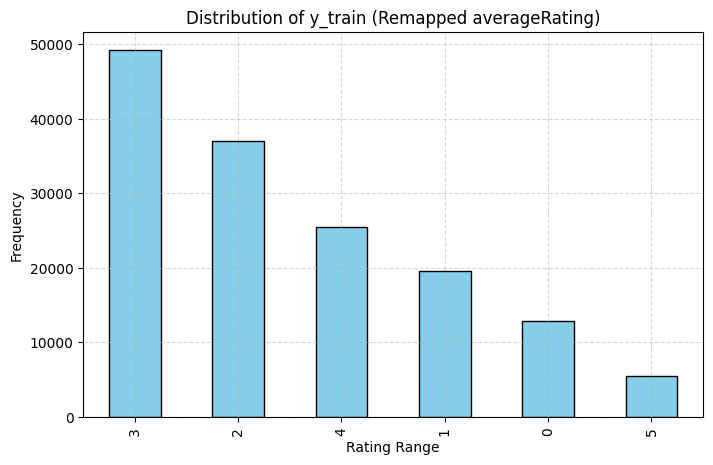

In [ ]:
# # Map values in intervals to new  bins
# def remap_rating(rating):
#     if rating < 5:
#         return 0
#     elif 5 <= rating < 6:
#         return 1
#     elif 6 <= rating < 7:
#         return 2
#     elif 7 <= rating < 8:
#         return 3
#     elif 8 <= rating < 9:
#         return 4
#     else:  # 9 <= rating <= 10
#         return 5
    
# # Remap y_train and y_test
# y = y.map(remap_rating)

# # Barplot the new distribution
# plt.figure(figsize=(8, 5))
# y.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
# plt.xlabel('Rating Range')
# plt.ylabel('Frequency')
# plt.title('Distribution of y_train (Remapped averageRating)')
# # plt.xticks(rotation=45)
# plt.grid(alpha=0.5, linestyle='--')
# plt.show()

In [37]:
y = pd.get_dummies(y, prefix='rating', dtype=int)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

In [ ]:
import numpy as np


to_log = [
       'numRegions', 'ratingCount', 'companiesNumber',
       'totalNominations', 'totalMedia', 'totalReviews']


for col in to_log:
    X_train[col] = np.log1p(X_train[col].fillna(0).clip(lower=0))
    X_val[col] = np.log1p(X_val[col].fillna(0).clip(lower=0))
    X_test[col] = np.log1p(X_test[col].fillna(0).clip(lower=0))

In [40]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_val[to_scale] = scaler.transform(X_val[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

In [41]:
# Counts for each class
y_train.value_counts().sort_index()

rating_0  rating_1  rating_2  rating_3  rating_4  rating_5
0         0         0         0         0         1            3070
                                        1         0           14774
                              1         0         0           28681
                    1         0         0         0           21640
          1         0         0         0         0           11363
1         0         0         0         0         0            7418
Name: count, dtype: int64

In [42]:
X_train = {
    'numerical': X_train[numerical_cols].values,
    'region': X_train[region_cols].values,
    'genre': X_train[genre_cols].values,
    'titletype': X_train[titletype_cols].values
}

X_val = {
    'numerical': X_val[numerical_cols].values,
    'region': X_val[region_cols].values,
    'genre': X_val[genre_cols].values,
    'titletype': X_val[titletype_cols].values
}

X_test = {
    'numerical': X_test[numerical_cols].values,
    'region': X_test[region_cols].values,
    'genre': X_test[genre_cols].values,
    'titletype': X_test[titletype_cols].values
}

In [43]:
from tensorflow.keras import layers
import tensorflow as tf

# Numerical Input
numerical_input = layers.Input(shape=(len(numerical_cols),), name='numerical')
numerical_branch = layers.Dense(96, use_bias=False)(numerical_input)
numerical_branch = layers.BatchNormalization()(numerical_branch)
numerical_branch = layers.Activation('swish')(numerical_branch)

# titletype branch
titletype_input = layers.Input(shape=(len(titletype_cols),), name='titletype')
titletype_branch = layers.Embedding(
    input_dim=2, output_dim=8, input_length=len(titletype_cols)
)(titletype_input)
titletype_branch = layers.Flatten()(titletype_branch)
titletype_branch = layers.Dense(8, use_bias=False)(titletype_branch)
titletype_branch = layers.BatchNormalization()(titletype_branch)
titletype_branch = layers.Activation('swish')(titletype_branch)

# genre branch
genre_input = layers.Input(shape=(len(genre_cols),), name='genre')
genre_branch = layers.Dense(8, use_bias=False)(genre_input)
genre_branch = layers.BatchNormalization()(genre_branch)
genre_branch = layers.Activation('swish')(genre_branch)

# region branch
region_input = layers.Input(shape=(len(region_cols),), name='region')
region_branch = layers.Dense(8, use_bias=False)(region_input)
region_branch = layers.BatchNormalization()(region_branch)
region_branch = layers.Activation('swish')(region_branch)

# Concatenate all branches
concatenated = layers.concatenate([numerical_branch, titletype_branch, genre_branch, region_branch])

# 1st layer
x = layers.Dense(256, use_bias=False)(concatenated)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
x = layers.Dropout(0.2)(x)

# 2nd layer
x = layers.Dense(128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
x = layers.Dropout(0.2)(x)

# 3rd layer
x = layers.Dense(64, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
x = layers.Dropout(0.2)(x)

# 4th layer
x = layers.Dense(64, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
x = layers.Dropout(0.2)(x)

# 5th layer
x = layers.Dense(32, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
x = layers.Dropout(0.2)(x)

# Output layer
output = layers.Dense(len(y_train.columns), activation='softmax')(x)

model_rating = tf.keras.Model(
    inputs=[numerical_input, titletype_input, genre_input, region_input],
    outputs=output
)

model_rating.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\tanya\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [44]:
%%time
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(y_train.shape[1]),
    y=np.argmax(y_train.values, axis=1)
)
class_weights = {i: class_weights[i] for i in range(y_train.shape[1])}

history_rating = model_rating.fit(
    X_train, y_train,
    epochs=500, batch_size=64, validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.2386 - loss: 1.6326 - val_accuracy: 0.2507 - val_loss: 1.6110
Epoch 2/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2619 - loss: 1.5499 - val_accuracy: 0.2693 - val_loss: 1.5980
Epoch 3/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2702 - loss: 1.5327 - val_accuracy: 0.2899 - val_loss: 1.5565
Epoch 4/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2794 - loss: 1.5164 - val_accuracy: 0.2943 - val_loss: 1.5614
Epoch 5/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2847 - loss: 1.5110 - val_accuracy: 0.2929 - val_loss: 1.5558
Epoch 6/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2880 - loss: 1.5029 - val_accuracy: 0.2986 - val_loss: 1.5429
Epoch 7/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2892 - loss: 1.4958 - val_accuracy: 0.2919 - val_loss: 1.5586
Epoch 8/500
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2934 - lo

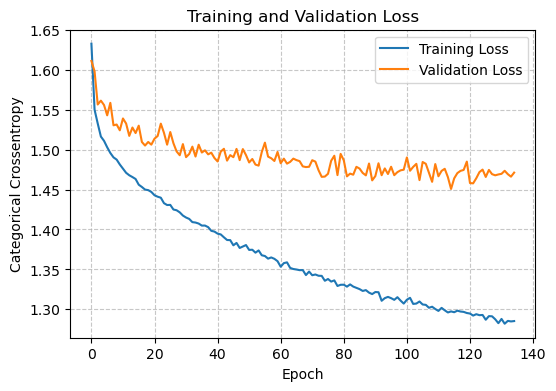

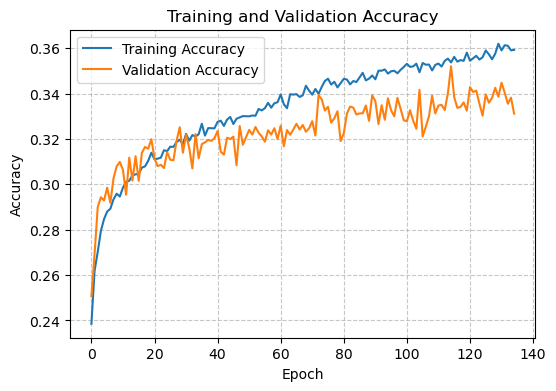

In [45]:
plt.figure(figsize=(6, 4))
plt.plot(history_rating.history['loss'], label='Training Loss')
plt.plot(history_rating.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history_rating.history['accuracy'], label='Training Accuracy')
plt.plot(history_rating.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

In [46]:
# Convert y_true_values to ndarray
y_true_classes = y_test.to_numpy()

906/906 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

      [1, 5)       0.32      0.51      0.39      2473
      [5, 6)       0.29      0.39      0.34      3787
      [6, 7)       0.42      0.22      0.29      7214
      [7, 8)       0.55      0.36      0.44      9561
      [8, 9)       0.30      0.36      0.33      4925
     [9, 10)       0.14      0.58      0.23      1023

    accuracy                           0.35     28983
   macro avg       0.34      0.40      0.33     28983
weighted avg       0.41      0.35      0.36     28983



<Figure size 400x400 with 0 Axes>

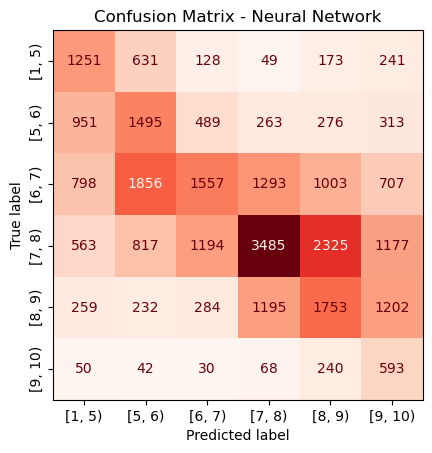

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np # Import numpy for argmax function

# Target names array is correctly ordered
target_names = [
    '[1, 5)',
    '[5, 6)',
    '[6, 7)',
    '[7, 8)',
    '[8, 9)',
    '[9, 10)'
]
                
# Predict on the test set
y_pred = model_rating.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_true_classes.argmax(axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

plt.figure(figsize=(4, 4))

# 1. Manually create the confusion matrix
# Use the corrected y_true_classes along with the predicted classes
cm = confusion_matrix(y_true_classes, y_pred_classes,)

# 2. Create a new ConfusionMatrixDisplay object with the original matrix and labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)


disp.xticks_rotation = 45

# 3. Plot the confusion matrix
disp.plot(cmap='Reds', colorbar=False)

plt.xticks(rotation=0)
plt.yticks(rotation=90, va='center')
plt.title('Confusion Matrix - Neural Network')
plt.show()

906/906 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
906/906 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
906/906 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
906/906 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
906/906 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
906/906 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


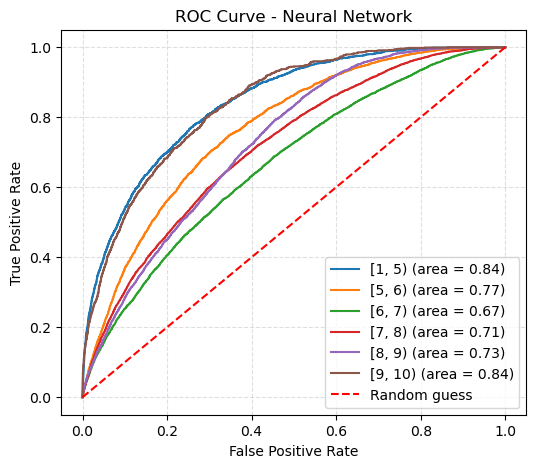

In [48]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_classes == i, model_rating.predict(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
for i in range(len(target_names)):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(target_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

In [49]:
# Save rating model
model_rating.save('neural_net_rating.keras')